<a href="https://colab.research.google.com/github/mathewhall100/ISIC-skin-lesion-identification/blob/master/ISIC_skin_lesions_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ISIC Skin Lesion Identification

Deep learning model to identifiy malignant from benign skin lesions. 

Data (5000 images -  approx 2000 of malignant melanoma and 3000 of benign nevi) was downloaded from the ISIC skin leasion archive  (https://www.isic-archive.com/#!/topWithHeader/onlyHeaderTop/gallery). Image processing was done on the command line using imageMagick and data saved as a 'train' folder containig all 5000 jpgs with corresponding csv files of image filenames with labels (label '0' = benign nevi, '1' = malignant melanoma)

Architecture : densenet161

Currently the model is achieving a best of around 88% accuracy in differentiating malignant melanoma from benign lesions.

## Notebook setup

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

In [0]:
!pip install nbformat
!pip install nbconvert==5.4.1


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Import libraries

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
from pandas import DataFrame

## Verify GPU status

In [16]:
print("GPU: ", torch.cuda.is_available())
print("Device = ", torch.device(torch.cuda.current_device()))
print("PyTorch version - ", torch.__version__)
print("Cuda version - ", torch.version.cuda)
print("cuDNN version - ", torch.backends.cudnn.version())
print("python PIL version - ", PIL.PILLOW_VERSION)

GPU:  True
Device =  cuda:0
PyTorch version -  1.1.0
Cuda version -  10.0.130
cuDNN version -  7501
python PIL version -  4.3.0


## Utilities

In [0]:
# Utility function to check for duplicates in a dataframe passed to it
def check_for_duplicates (df):
  df_set = set(df)
  if len(df_set) < len(df):
    return "duplicates found"
  else: return "none"

In [0]:
# Utility function to check there are no missing image files or labels
def check_for_missing(labels, files):
  labels_set = set(labels)
  files_set = set(files)
  dif1 = labels_set - files_set
  dif2 = files_set - labels_set
  if len(dif1) > 0: 
    return "There are missing image files (more labels then images)!"
  elif len(dif2) > 0:
    return "There are missing labels (more images than labels)!"
  else: return "none"

In [0]:
# Utility function to plot a single image from 'train' folder
def plot_one(path, file):
  img = plt.imread(f'{path}/train/{file}')
  plt.imshow(img)

In [0]:
# Utility function to plot a series of images from 'train' folder
def plot_many(path, files):
  f, axarr = plt.subplots(3,3)
  for x in range(3):
    for y in range(3):
      z=(x*3)+y
      img = plt.imread(f'{path}/train/{files[z]}')
      plt.axis('off')
      axarr[x,y].imshow(img)

## Define parameters

In [0]:
bs_resnet34 = 64
bs_densenet = 16 
sz_sm = 224
sz_lg = 250

In [22]:
PATH = root_dir + "Colab Notebooks/data/ISIC/"
os.listdir(PATH)

['models',
 'labels_bn.csv',
 '.ipynb_checkpoints',
 'labels_mm2.csv',
 'labels_mm.csv',
 'train',
 'report.pdf']

## Get data

*Note label '0' = benign nevi,  label '1' = maligmelanoma

In [23]:
# Get image files from 'train folder'
train_files = os.listdir(f'{PATH}/train');
train_files[:5]

['ISIC_0033331.jpg',
 'ISIC_0033332.jpg',
 'ISIC_0033334.jpg',
 'ISIC_0033335.jpg',
 'ISIC_0033338.jpg']

In [24]:
# Get filenames of maligmelanoma images and load into dataframe
df_mm = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/ISIC/labels_mm.csv')
print("Images maligmelanoma: ", len(df_mm))
print(df_mm.head())

Images maligmelanoma:  2088
                  0  label
0  ISIC_0011112.jpg      1
1  ISIC_0031795.jpg      1
2  ISIC_0014189.jpg      1
3  ISIC_0026622.jpg      1
4  ISIC_0010329.jpg      1


In [25]:
# Get filenames of benign nevi images and load into dataframe
df_bn = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/ISIC/labels_bn.csv')
print("Images benign nevi: ", len(df_bn))
print(df_bn.head())

Images benign nevi:  3000
                  0  label
0  ISIC_0032832.jpg      0
1  ISIC_0026974.jpg      0
2  ISIC_0032785.jpg      0
3  ISIC_0032342.jpg      0
4  ISIC_0031635.jpg      0


In [26]:
# Combine the two label files into one for passing into Databunch
df_labels = pd.concat([df_mm, df_bn], ignore_index=True)
print("Images total: ", len(df_labels))
print(df_labels.head())
print(df_labels.tail())

Images total:  5088
                  0  label
0  ISIC_0011112.jpg      1
1  ISIC_0031795.jpg      1
2  ISIC_0014189.jpg      1
3  ISIC_0026622.jpg      1
4  ISIC_0010329.jpg      1
                     0  label
5083  ISIC_0027237.jpg      0
5084  ISIC_0031809.jpg      0
5085  ISIC_0033474.jpg      0
5086  ISIC_0028000.jpg      0
5087  ISIC_0010719.jpg      0


## Examine data

In [27]:
# Get list of labels from dataframe column 0
label_files = df_labels["0"]
label_files[:5]

0    ISIC_0011112.jpg
1    ISIC_0031795.jpg
2    ISIC_0014189.jpg
3    ISIC_0026622.jpg
4    ISIC_0010329.jpg
Name: 0, dtype: object

In [28]:
print('Data Integrity Check')
print('---------------------------')

data = {"number": [len(train_files), len(label_files)],
        "duplicates": [check_for_duplicates(train_files), check_for_duplicates(label_files)],
        "missing": [check_for_missing(label_files, train_files), check_for_missing(label_files, train_files)]}
frame = pd.DataFrame(data, columns=["number", "duplicates", "missing"], index=["images","labels"])
frame


Data Integrity Check
---------------------------


,number,duplicates,missing
images,5088,none,none
labels,5088,none,none


maligmelanoma


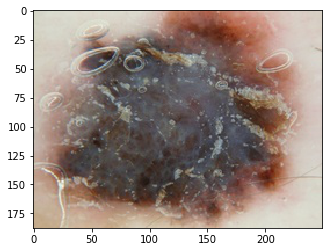

In [29]:
labels_mm = df_mm["0"]
print('maligmelanoma')
plot_one(PATH, labels_mm[0])
              

maligmelanomas


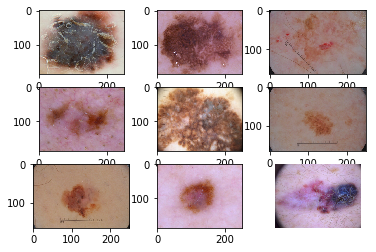

In [30]:
print("maligmelanomas")
plot_many(PATH, labels_mm[:9])

benign nevi


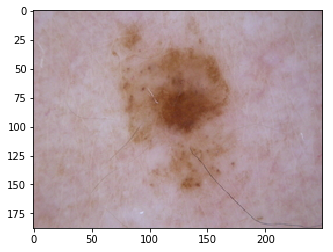

In [31]:
labels_bn = df_bn["0"]
print('benign nevi')
plot_one(PATH, labels_bn[0])

benign nevi


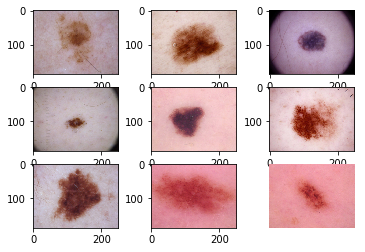

In [32]:
print("benign nevi")
plot_many(PATH, labels_bn[:9])

## Create DataBunch object 

** note bs must be 16 to allow model to run within 14GB GPU memory

In [0]:
data_path = PATH + "train"

In [0]:
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
train_img = (ImageList.from_df(df_labels, data_path)
        .split_by_rand_pct(0.2)
        .label_from_df()
        .transform(trfm, size=sz_sm)
        .databunch(path='.', bs=bs_densenet, device=torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

In [35]:
train_img


ImageDataBunch;

Train: LabelList (4071 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: /content/gdrive/My Drive/Colab Notebooks/data/ISIC/train;

Valid: LabelList (1017 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,0,0,0
Path: /content/gdrive/My Drive/Colab Notebooks/data/ISIC/train;

Test: None

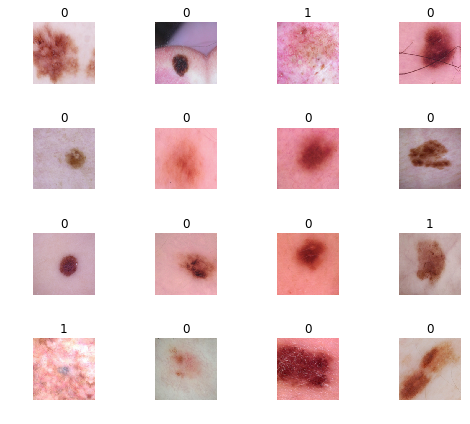

In [36]:
train_img.show_batch(rows=4, figsize=(7,6))

In [37]:
learn = cnn_learner(train_img, models.densenet161, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:03<00:00, 29706823.23it/s]


## Learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


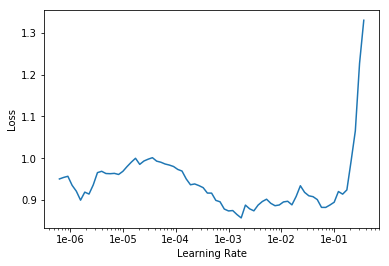

In [38]:
learn.lr_find()
learn.recorder.plot()

## Fit

In [39]:
lr = 5e-04
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.635727,0.585465,0.236971,0.763029,18:26
1,0.520972,0.407321,0.176008,0.823992,01:27
2,0.420803,0.346257,0.171091,0.828909,01:26
3,0.372901,0.314194,0.140610,0.859390,01:26
4,0.355656,0.302884,0.138643,0.861357,01:25


## Interpret results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

'0' = benign nevi, '1' = malignant melanoma


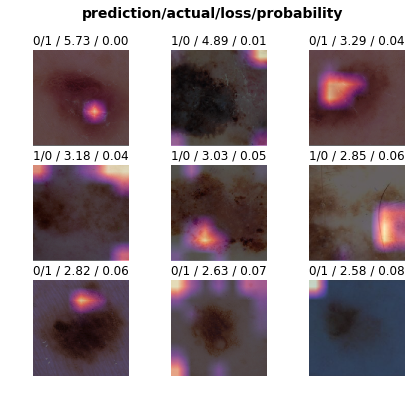

In [41]:
print("'0' = benign nevi, '1' = malignant melanoma")
interp.plot_top_losses(9, figsize=(7,6))

'0' = benign nevi, '1' = malignant melanoma


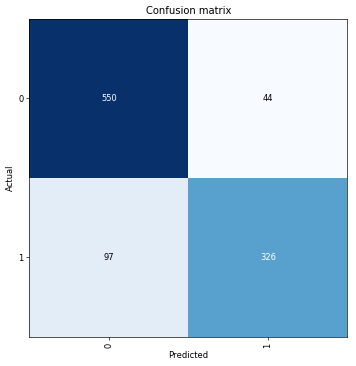

In [42]:
print("'0' = benign nevi, '1' = malignant melanoma")
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

## Save Model

In [0]:
learn.save(root_dir + 'Colab Notebooks/data/ISIC/models/skin_lesion_id_base_densenet')

## Load correct model

In [0]:
learn.load(root_dir + 'Colab Notebooks/data/ISIC/models/skin_lesion_id_base_densenet')

## Unfreeze

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


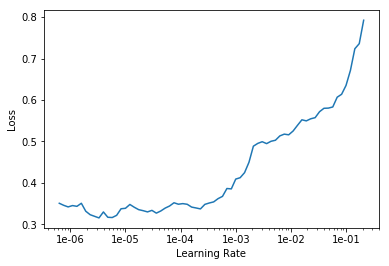

In [45]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


In [46]:
learn.fit_one_cycle(10, wd=1.0, max_lr=slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.377349,0.302153,0.131760,0.868240,01:54
1,0.366729,0.314138,0.141593,0.858407,01:54
2,0.343207,0.293442,0.129794,0.870206,01:53
3,0.326379,0.276096,0.124877,0.875123,01:53
4,0.284331,0.281946,0.127827,0.872173,01:53
5,0.281685,0.277695,0.124877,0.875123,01:53
6,0.216056,0.254995,0.115044,0.884956,01:53
7,0.228848,0.258401,0.116028,0.883972,01:53
8,0.194991,0.253467,0.116028,0.883972,01:53
9,0.202855,0.254093,0.117994,0.882006,01:53


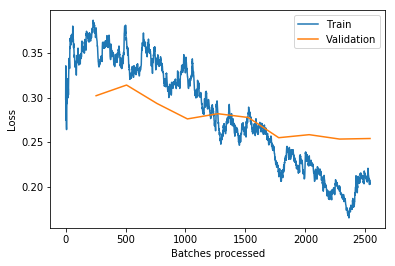

In [47]:
learn.recorder.plot_losses()

## Save model &  export for deployment

In [0]:
learn.save(root_dir + 'Colab Notebooks/data/ISIC/models/skin_lesion_id_stage2_densenet')
learn.export(root_dir + 'Colab Notebooks/data/ISIC/models/export.pkl')

## Interpret results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

'0' = benign nevi, '1' = malignant melanoma


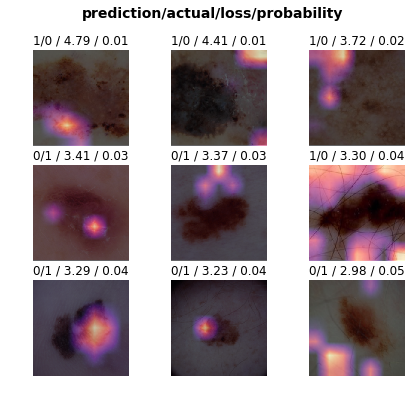

In [50]:
print("'0' = benign nevi, '1' = malignant melanoma")
interp.plot_top_losses(9, figsize=(7,6))

'0' = benign nevi, '1' = malignant melanoma


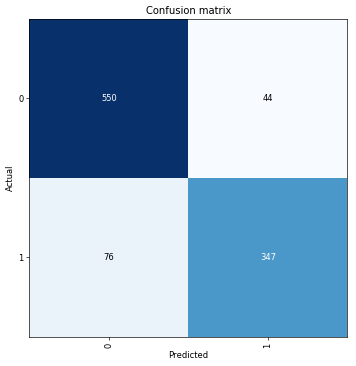

In [51]:
print("'0' = benign nevi, '1' = malignant melanoma")
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)